<a href="https://colab.research.google.com/github/Zuoyu2524/BNN/blob/main/Bayesian_Neural_Network_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bayesian Neural Network method
Here we first use a basic Bayesian neural network to learn the given features (area of attack, industry, victim, etc.) through supervised learning methods to first analyze which type of attack is most probable for the object, and then analyze the specific possible attack events and the corresponding probabilities.

We will use two types of data pre-processing for training and testing respectively.

For an introduction to Bayesian neural networks, see：https://arxiv.org/ftp/arxiv/papers/1801/1801.07710.pdf

Helpful documentation on implementing Bayesian networks：

https://pyro4ci.readthedocs.io/en/latest/contrib.bnn.html

https://zenodo.org/record/5908307#.Yv-TEXZBxD-

https://github.com/DoctorLoop/BayesianDeepLearning

###Install the pyro library

In [ ]:
!pip3 install pyro-ppl==1.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 573 kB 8.1 MB/s 


###Import all required modules

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import pyro
from pyro.distributions import Normal
from pyro.distributions import Categorical
from pyro.optim import Adam
from pyro.infer import SVI
from pyro.infer import Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

###Preparing the data set

In [ ]:
import pandas as pd
import csv

df = pd.read_csv("/content/datas with labels.csv", header=0, encoding='latin1',names=['f','g',
          'h', 'i', 'j',
          'k', 'l', 'm',
          'n', 'o', 'p'
          ])
#Converting pandas table data into a list
list1 = df.values.tolist()
labels_set = np.array(list1)

In [ ]:
class getDataset(Dataset):
    def __init__(self, path_data, labels):
      data = np.load(path_data, allow_pickle=True).astype(np.float32)
      label = labels.astype(np.float32)

      self.x_data = torch.from_numpy(data)
      self.y_data = torch.from_numpy(labels)
      self.len = data.shape[0]

    def __getitem__(self, index):
      return self.x_data[index], self.y_data[index]

    def __len__(self):
      return self.len

###Making the train and test data set

In [ ]:
myDataset = getDataset('/content/wordvector.npy',labels_set)
train_data, test_data = random_split(myDataset,[int(len(myDataset)*0.9), len(myDataset)-int(len(myDataset)*0.9)])

###Building a Bayesian MLP network structure

In [ ]:
class BNN_net(nn.Module):
    def __init__(self, input_features):
        super(BNN_net, self).__init__()
        self.fc1 = nn.Linear(input_features, 502)
        self.fc2 = nn.Linear(502, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 11)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
net = BNN_net(750)

###Based on normal distribution, initialize weights and bias

In [ ]:
def model(x_data, y_data):
    # define prior destributions
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))

    fc2w_prior = Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    fc2b_prior = Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))

    fc3w_prior = Normal(loc=torch.zeros_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
    fc3b_prior = Normal(loc=torch.zeros_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))

    fc4w_prior = Normal(loc=torch.zeros_like(net.fc4.weight), scale=torch.ones_like(net.fc4.weight))
    fc4b_prior = Normal(loc=torch.zeros_like(net.fc4.bias), scale=torch.ones_like(net.fc4.bias))

    priors = {
        'fc1.weight': fc1w_prior,
        'fc1.bias': fc1b_prior,
        'fc2.weight': fc2w_prior,
        'fc2.bias': fc2b_prior,
        'fc3.weight': fc3w_prior,
        'fc3.bias': fc3b_prior,
        'fc4.weight': fc4w_prior,
        'fc4.bias': fc4b_prior}


    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()

    probs = F.sigmoid(lifted_reg_model(x_data))
    pyro.enable_validation(False)
    pyro.sample("obs", Categorical(logits=probs), obs=y_data)

###Create approximate posterior probability distributions

In [ ]:
def guide(x_data, y_data):
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = F.softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)

    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = F.softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = F.softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)

    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = F.softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)

    fc3w_mu = torch.randn_like(net.fc3.weight)
    fc3w_sigma = torch.randn_like(net.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = F.softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3w_prior = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param).independent(1)

    fc3b_mu = torch.randn_like(net.fc3.bias)
    fc3b_sigma = torch.randn_like(net.fc3.bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = F.softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3b_prior = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)

    fc4w_mu = torch.randn_like(net.fc4.weight)
    fc4w_sigma = torch.randn_like(net.fc4.weight)
    fc4w_mu_param = pyro.param("fc4w_mu", fc4w_mu)
    fc4w_sigma_param = F.softplus(pyro.param("fc4w_sigma", fc4w_sigma))
    fc4w_prior = Normal(loc=fc4w_mu_param, scale=fc4w_sigma_param)

    fc4b_mu = torch.randn_like(net.fc4.bias)
    fc4b_sigma = torch.randn_like(net.fc4.bias)
    fc4b_mu_param = pyro.param("fc4b_mu", fc4b_mu)
    fc4b_sigma_param = F.softplus(pyro.param("fc4b_sigma", fc4b_sigma))
    fc4b_prior = Normal(loc=fc4b_mu_param, scale=fc4b_sigma_param)

    priors = {
        'fc1.weight': fc1w_prior,
        'fc1.bias': fc1b_prior,
        'fc2.weight': fc2w_prior,
        'fc2.bias': fc2b_prior,
        'fc3.weight': fc3w_prior,
        'fc3.bias': fc3b_prior,
        'fc4.weight': fc4w_prior,
        'fc4.bias': fc4b_prior}

    lifted_module = pyro.random_module("module", net, priors)

    return lifted_module()

###SVI variational inference approximates the posterior probability distribution

In [ ]:
optimi = Adam({"lr": 0.001})
svi = SVI(model, guide, optimi, loss=Trace_ELBO())

###Train module

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

In [ ]:
n_iterations = 30
loss = 0.0

for j in range(n_iterations):
    loss = 0.0
    running_loss = 0.0
    for batch_id, data in enumerate(train_loader):
      loss += svi.step(data[0].view(-1,5*150), data[1].view(1*11,-1))

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train

    loss_list.append(total_epoch_loss_train)
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  24.239655508959714
Epoch  1  Loss  23.987741598631516
Epoch  2  Loss  24.072620603358423
Epoch  3  Loss  24.069777999753104
Epoch  4  Loss  24.062816101226787
Epoch  5  Loss  24.08464907612972
Epoch  6  Loss  23.855202010321026
Epoch  7  Loss  23.948485426728734
Epoch  8  Loss  23.90374701127458
Epoch  9  Loss  23.83462024278498
Epoch  10  Loss  23.736030437249166
Epoch  11  Loss  23.717716042202948
Epoch  12  Loss  23.8131540464098
Epoch  13  Loss  23.905896014791153
Epoch  14  Loss  24.04405878280663
Epoch  15  Loss  23.991803657890216
Epoch  16  Loss  24.068371982011673
Epoch  17  Loss  23.97599558749577
Epoch  18  Loss  24.07129858390649
Epoch  19  Loss  24.040000368874985
Epoch  20  Loss  23.7936856162213
Epoch  21  Loss  23.823697325933598
Epoch  22  Loss  23.856253819738363
Epoch  23  Loss  23.69075054709619
Epoch  24  Loss  23.629427568576766
Epoch  25  Loss  23.562908098591304
Epoch  26  Loss  23.549509643791538
Epoch  27  Loss  23.429315870282633
Epoch  28  Lo

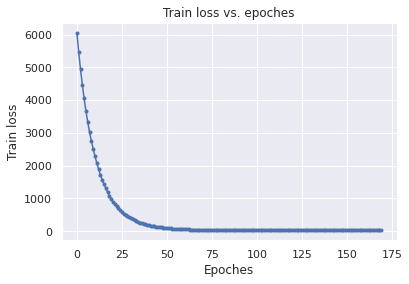

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list, '.-')
plt.title('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.xlabel('Epoches')
plt.show()

###Test Module

Determine whether each type of attack is likely to occur based on the normalized probability distribution

In [ ]:
def get_labels(x, mean):
  labels = []
  #print(x[0])
  for i in x[0]:
    if i.item()<mean:
      labels.append(0.0)
    else:
      labels.append(1.0)
  return labels

Data normalization

In [ ]:
def normalize(x):
  return (x - x.min()) / (x.max() - x.min())

In [ ]:
def predict_label(x):
  proba = []
  #Since the output result is 11, the number of samples here is 11
  n_samples = 11
  sampled_models = [guide(None, None) for _ in range(n_samples)]
  yhats = [model(x).data for model in sampled_models]
  mean = torch.mean(torch.stack(yhats), 0)
  average = 0
  for i in range(n_samples):
     single = F.softmax(torch.Tensor(normalize(mean.numpy()))[0])
     proba.append(single)
     average += torch.mean(single).item()
  #print(average/11)
  labels = get_labels(proba, average/11)
  return torch.tensor(labels, dtype=torch.float32)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(test_loader):
    inputs, labels = data[0].view(-1,5*150), data[1].view(-1,1*11)
    predict = predict_label(inputs)
    #print(labels)
    #print(predict)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

    if i % 100 == 99:
      print('batch: %5d,\t acc: %f' % (i + 1, correct / (total*10)))
  print('Accuracy: %.2f%%' % (correct / total*10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


batch:   100,	 acc: 0.912000
batch:   200,	 acc: 0.923500
batch:   300,	 acc: 0.926667
batch:   400,	 acc: 0.926250
batch:   500,	 acc: 0.926600
batch:   600,	 acc: 0.925833
batch:   700,	 acc: 0.924000
Accuracy: 92.31%
